In [244]:
# Import all the necessary libraries for data analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import numpy as np
import re
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold

In [245]:
# Install packages if needed

# !pip install pandas
# !pip install numpy
# !pip install matplotlib
# !pip install imblearn
# !pip install seaborn
# !pip install plotly
# !pip install scikit-learn
# !pip install missingno
# !pip install xgboost
# !pip install lightgbm
# !pip install catboost

In [246]:
# Load files
path = "../inter-uni-datathon-2024-nsw/"
train_data = pd.read_csv(path + "train.csv")
test_df = pd.read_csv(path + "test.csv")

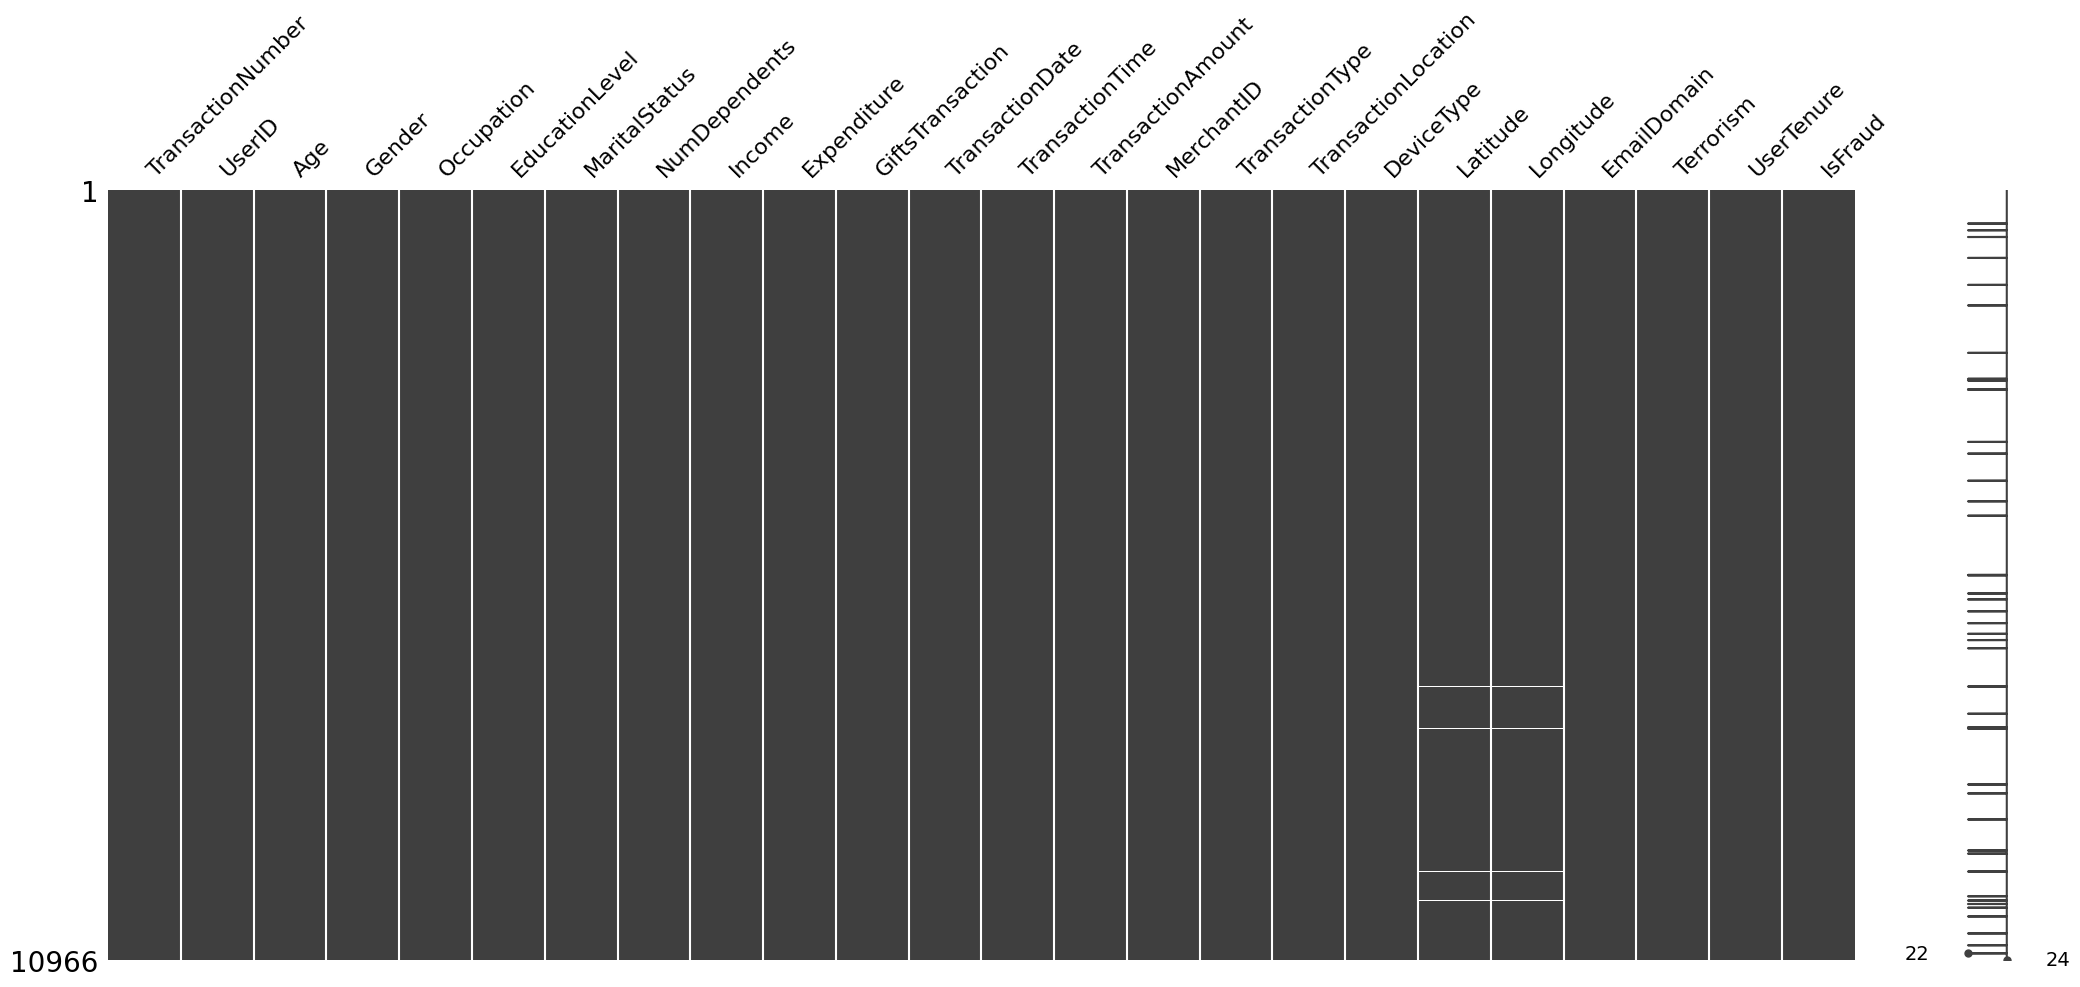

<Figure size 1500x900 with 0 Axes>

In [247]:
# Missing data
msno.matrix(train_data)
plt.figure(figsize = (15,9))
plt.show()

In [248]:
def get_numerical_summary(df):
    total = df.shape[0]
    missing_columns = [col for col in df.columns if df[col].isnull().sum() > 0]
    missing_percent = {}
    for col in missing_columns:
        null_count = df[col].isnull().sum()
        per = (null_count/total) * 100
        missing_percent[col] = per
        print("{} : {} ({}%)".format(col, null_count, round(per, 3)))
    return missing_percent

missing_percent = get_numerical_summary(train_data)

Latitude : 43 (0.392%)
Longitude : 43 (0.392%)


In [249]:
# Drop rows with missing values since they are few
train_data.dropna(inplace=True)

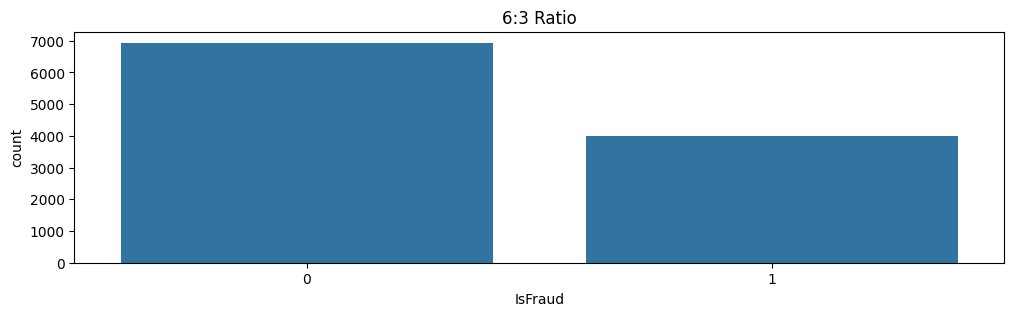

In [250]:
# Check the number of 0 and 1 in the IsFraud column, gimme ratio
train_data['IsFraud'].value_counts(normalize=True)
sns.countplot(x='IsFraud', data=train_data)
plt.title('6:3 Ratio')
plt.show()

In [251]:
# Undersampler to balance the dataset (6:3 ratio)
rus = RandomUnderSampler(sampling_strategy='majority')
X_rus, y_rus = rus.fit_resample(train_data.drop(columns=['IsFraud']), train_data['IsFraud'])
train_data = pd.concat([X_rus, y_rus], axis=1)

## Cleaning

### Cities

In [252]:
city_mapping = {
    'Canberra': 'Canberra',
    'CBR': 'Canberra',
    'Cbr': 'Canberra',
    'canberra': 'Canberra',
    'Darwin': 'Darwin',
    'Drw': 'Darwin',
    'DRW': 'Darwin',
    'darwin': 'Darwin',
    'Hobart': 'Hobart',
    'hobart': 'Hobart',
    'HBT': 'Hobart',
    'Hbt': 'Hobart',
    'Brisbane': 'Brisbane',
    'Bne': 'Brisbane',
    'BNE': 'Brisbane',
    'brisbane': 'Brisbane',
    'Adelaide': 'Adelaide',
    'adl': 'Adelaide',
    'Adl': 'Adelaide',
    'Adelaide City': 'Adelaide',
    'Sydney': 'Sydney',
    'SYD': 'Sydney',
    'Syd': 'Sydney',
    'sydney': 'Sydney',
    'Perth': 'Perth',
    'perth': 'Perth',
    'Pth': 'Perth',
    'PTH': 'Perth',
    'Melbourne': 'Melbourne',
    'Mel': 'Melbourne',
    'melbourne': 'Melbourne',
    'Melb': 'Melbourne',
    'Melburn': 'Melbourne',
    'MLB': 'Melbourne'
}

train_data['TransactionLocation'] = train_data['TransactionLocation'].replace(city_mapping) 

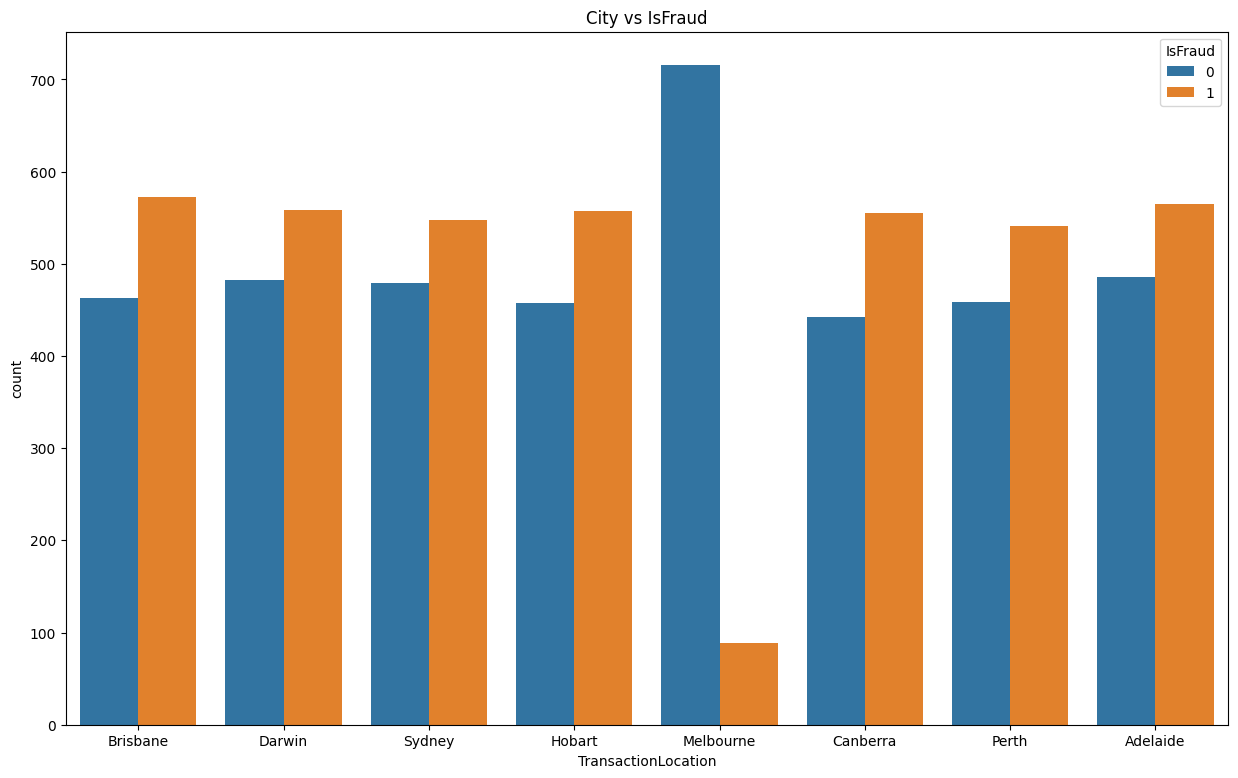

In [253]:
# Plot city against IsFraud
plt.figure(figsize=(15, 9))
sns.countplot(x='TransactionLocation', hue='IsFraud', data=train_data)
plt.title('City vs IsFraud')
plt.show()

### Datetime

In [254]:
def standard_time(time_str):
    try:
        if 'AM' in time_str or 'PM' in time_str:
            return pd.to_datetime(time_str, format='%I:%M:%S %p').strftime('%H:%M:%S')
        
        return pd.to_datetime(time_str, format='%H:%M:%S').strftime('%H:%M:%S')
    
    except (ValueError, TypeError):
        try:
            parts = time_str.split('/')
            corrected_time = f'{parts[0]}:{parts[1]}:{parts[2]}'
            return pd.to_datetime(corrected_time, format='%H:%M:%S').strftime('%H:%M:%S')
        except Exception:
            return

def categorize_time(hour):
    if 0 <= hour < 6:
        return 'Night'
    elif 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'


train_data['TransactionTime'] = train_data['TransactionTime'].apply(standard_time)
# apply categorize_time function to TransactionTime column
train_data['TransactionTime'] = pd.to_datetime(train_data['TransactionTime'], format='%H:%M:%S').dt.hour
train_data['TransactionTime'] = train_data['TransactionTime'].apply(categorize_time)
    # Keep only the domain after @ for EmailDomain

# train_data['TransactionDate'] = pd.to_datetime(train_data['TransactionDate'], dayfirst=True)
train_data['TransactionDate'] = pd.to_datetime(train_data['TransactionDate'], format='mixed', dayfirst=True, errors='coerce')

train_data['Date'] = train_data['TransactionDate'].dt.day   
train_data['Month'] = train_data['TransactionDate'].dt.month  
train_data['Weekday'] = train_data['TransactionDate'].dt.day_name()

# Drop the TransactionDate column
train_data.drop(columns=['TransactionDate'], inplace=True)

In [255]:
# Categorical columns
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7970 entries, 3895 to 10965
Data columns (total 26 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   TransactionNumber    7970 non-null   int64  
 1   UserID               7970 non-null   int64  
 2   Age                  7970 non-null   int64  
 3   Gender               7970 non-null   object 
 4   Occupation           7970 non-null   object 
 5   EducationLevel       7970 non-null   object 
 6   MaritalStatus        7970 non-null   object 
 7   NumDependents        7970 non-null   int64  
 8   Income               7970 non-null   object 
 9   Expenditure          7970 non-null   object 
 10  GiftsTransaction     7970 non-null   object 
 11  TransactionTime      7970 non-null   object 
 12  TransactionAmount    7970 non-null   object 
 13  MerchantID           7970 non-null   object 
 14  TransactionType      7970 non-null   object 
 15  TransactionLocation  7970 non-null   ob

### Clean currency data (4 columns)

In [256]:
def get_currency_and_symbol(val):
    if 'AUD' in val or 'AU' in val:
        # create a feature for aud
        return re.sub(r'[^\d.]', '', val), 'AUD' 
    elif 'AED' in val:
        value = re.sub(r'[^\d.]', '', val)
        # convert AED to AUD
        return float(value) * 0.35, 'AED'
    elif '£' in val:
        value = re.sub(r'[^\d.]', '', val)
        # convert pounds to AUD
        return float(value) * 1.8, 'GBP'
    elif 'GBP' in val:
        value = re.sub(r'[^\d.]', '', val)
        # convert pounds to AUD
        return float(value) * 1.8, 'GBP'
    else:
        return "Unidentified", "Unknown" 


# Apply to Income
train_data['Income'], train_data['Income_Currency'] = zip(*train_data['Income'].apply(get_currency_and_symbol))
train_data['Income'] = pd.to_numeric(train_data['Income'], errors='coerce')  

# Apply to Expenditure
train_data['Expenditure'], train_data['Expenditure_Currency'] = zip(*train_data['Expenditure'].apply(get_currency_and_symbol))
train_data['Expenditure'] = pd.to_numeric(train_data['Expenditure'], errors='coerce')

# Apply to GiftsTransaction
train_data['GiftsTransaction'], train_data['GiftsTransaction_Currency'] = zip(*train_data['GiftsTransaction'].apply(get_currency_and_symbol))
train_data['GiftsTransaction'] = pd.to_numeric(train_data['GiftsTransaction'], errors='coerce')

# Apply to TransactionAmount
train_data['TransactionAmount'], train_data['TransactionAmount_Currency'] = zip(*train_data['TransactionAmount'].apply(get_currency_and_symbol))
train_data['TransactionAmount'] = pd.to_numeric(train_data['TransactionAmount'], errors='coerce') 

### Separte data into 3 groups for faster computation/Quick correlation analysis (Remove?)

In [257]:
# Age (does young adult cause more fraud?)
user_info = [
    "Age", 
    "Gender",
    "Terrorism",
    "Income",
    "MaritalStatus",
    "Occupation",
    "EducationLevel",
    "NumDependents",
    "GiftsTransaction" 
]
transaction_info = [
    "TransactionType", 
    "TransactionTime", 
    "TransactionAmount",
    "TransactionLocation",
    "MerchantID",
    "DeviceType"
]
account_info = [
    "UserTenure",
    "Expenditure",
    "Latitude",
    "Longitude",
    "EmailDomain"
]

In [258]:
# Convert categorical data to numerical data through One Hot Encoding
user_df = pd.get_dummies(train_data[user_info])
transaction_df = pd.get_dummies(train_data[transaction_info])
account_df = pd.get_dummies(train_data[account_info])
# Append IsFraud to the all dfs
user_df['IsFraud'] = train_data['IsFraud']
transaction_df['IsFraud'] = train_data['IsFraud']
account_df['IsFraud'] = train_data['IsFraud']

In [259]:
# Calculate correlations once for each DataFrame
user_corr = user_df.corrwith(user_df['IsFraud'])
transaction_corr = transaction_df.corrwith(transaction_df['IsFraud'])
account_corr = account_df.corrwith(account_df['IsFraud'])

# Sort the correlations in descending order
user_corr = user_corr.sort_values(ascending=False)
transaction_corr = transaction_corr.sort_values(ascending=False)
account_corr = account_corr.sort_values(ascending=False)


In [260]:
user_corr.head(10)

IsFraud                   1.000000
MaritalStatus_Divorced    0.038581
EducationLevel_PhD        0.022460
Occupation_Student        0.020560
Gender_woman              0.016069
Terrorism                 0.013602
Income                    0.009939
Occupation_Unemployed     0.008888
Gender_Male               0.008334
GiftsTransaction          0.007175
dtype: float64

In [261]:
transaction_corr.head(10)

IsFraud                          1.000000
TransactionTime_Late Night       0.554033
TransactionType_Withdrawal       0.527303
TransactionAmount                0.100212
TransactionTime_Early Morning    0.066314
TransactionLocation_Canberra     0.042857
TransactionLocation_Brisbane     0.040685
TransactionLocation_Hobart       0.037261
TransactionLocation_Perth        0.031060
TransactionLocation_Adelaide     0.029296
dtype: float64

In [262]:
account_corr

IsFraud                                  1.000000
EmailDomain_smithsamantha@outlook.com    0.031698
EmailDomain_vthomas@gmail.com            0.031698
EmailDomain_rgarcia@gmail.com            0.029649
EmailDomain_silvawilliam@outlook.com     0.029649
                                           ...   
EmailDomain_brenda02@gmail.com          -0.025055
EmailDomain_nicholasreeves@yahoo.com    -0.025055
EmailDomain_jharris@gmail.com           -0.027448
EmailDomain_ndavis@gmail.com            -0.027448
EmailDomain_cstark@gmail.com            -0.027448
Length: 3893, dtype: float64

### Clean email domain

In [263]:
# Keep only the domain after @ for EmailDomain
train_data['EmailDomain'] = train_data['EmailDomain'].apply(lambda x: x.split('@')[1])

### Gender mapping

In [264]:
gender_mapping = {
    'fem': 'Female',
    'Female': 'Female',
    'she': 'Female',
    'woman': 'Female',
    'he': 'Male',
    'man': 'Male',
    'Male': 'Male',
    'isnotfemale': 'Male',
    'isnotmale': 'Female',
}

train_data['Gender'] =train_data['Gender'].map(gender_mapping).fillna('Other')

### Device mapping

In [265]:
# Group mob, smartphone, iphone 15, galaxys7, android to Mobile
train_data['DeviceType'] = train_data['DeviceType'].apply(lambda x: 'Mobile' if x in ['mob', 'smartphone', 'iphone 15', 'galaxys7', 'android'] else x)

## EDA

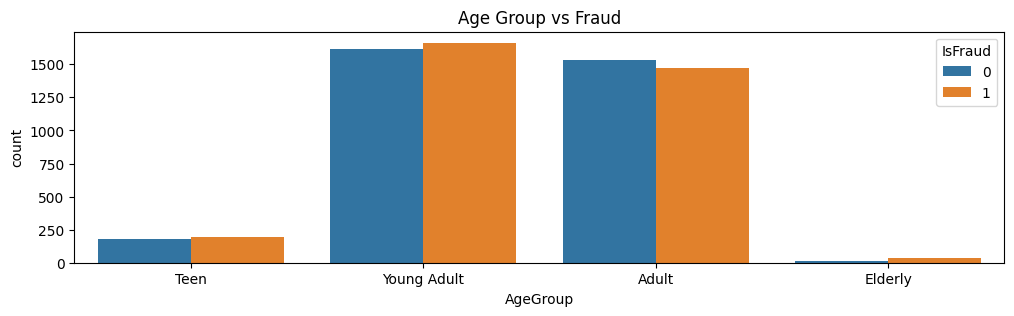

In [266]:
# What age group is more likely to commit fraud?
train_data['AgeGroup'] = pd.cut(train_data['Age'], bins=[0, 18, 35, 60, 100], labels=['Teen', 'Young Adult', 'Adult', 'Elderly'])

# Plot the AgeGroup column
sns.countplot(x='AgeGroup', data=train_data, hue='IsFraud')
plt.title('Age Group vs Fraud')
plt.show()

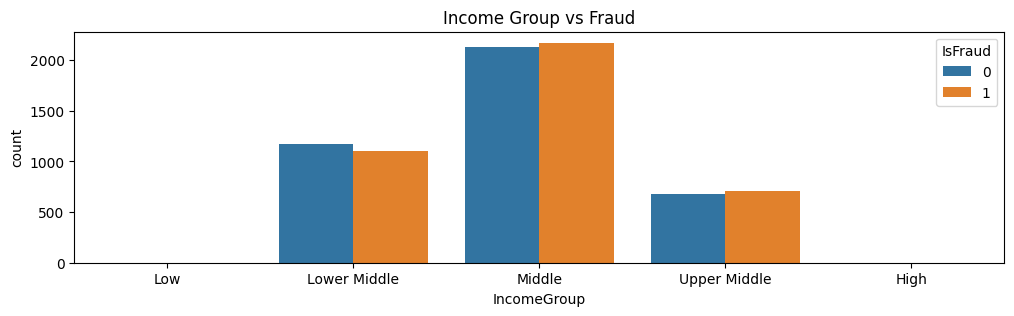

In [267]:
# Are lower-income individuals more likely to commit fraud, or do high-income individuals also play a role?
train_data['IncomeGroup'] = pd.cut(train_data['Income'], bins=[0, 10000, 50000, 100000, 500000, 1000000], labels=['Low', 'Lower Middle', 'Middle', 'Upper Middle', 'High'])

# Plot the IncomeGroup column
sns.countplot(x='IncomeGroup', data=train_data, hue='IsFraud')
plt.title('Income Group vs Fraud')
plt.show()

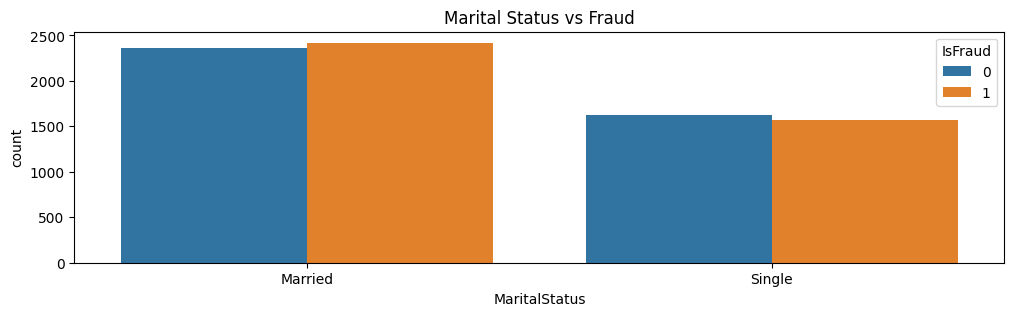

In [268]:
# Determine if couples or single individuals are more prone to committing fraud. Are certain relationship statuses (e.g., married, single) associated with higher fraud risk?
train_data['MaritalStatus'] = train_data['MaritalStatus'].apply(lambda x: 'Single' if x == 'Single' else 'Married')

# Plot the MaritalStatus column
sns.countplot(x='MaritalStatus', data=train_data, hue='IsFraud')
plt.title('Marital Status vs Fraud')
plt.show()

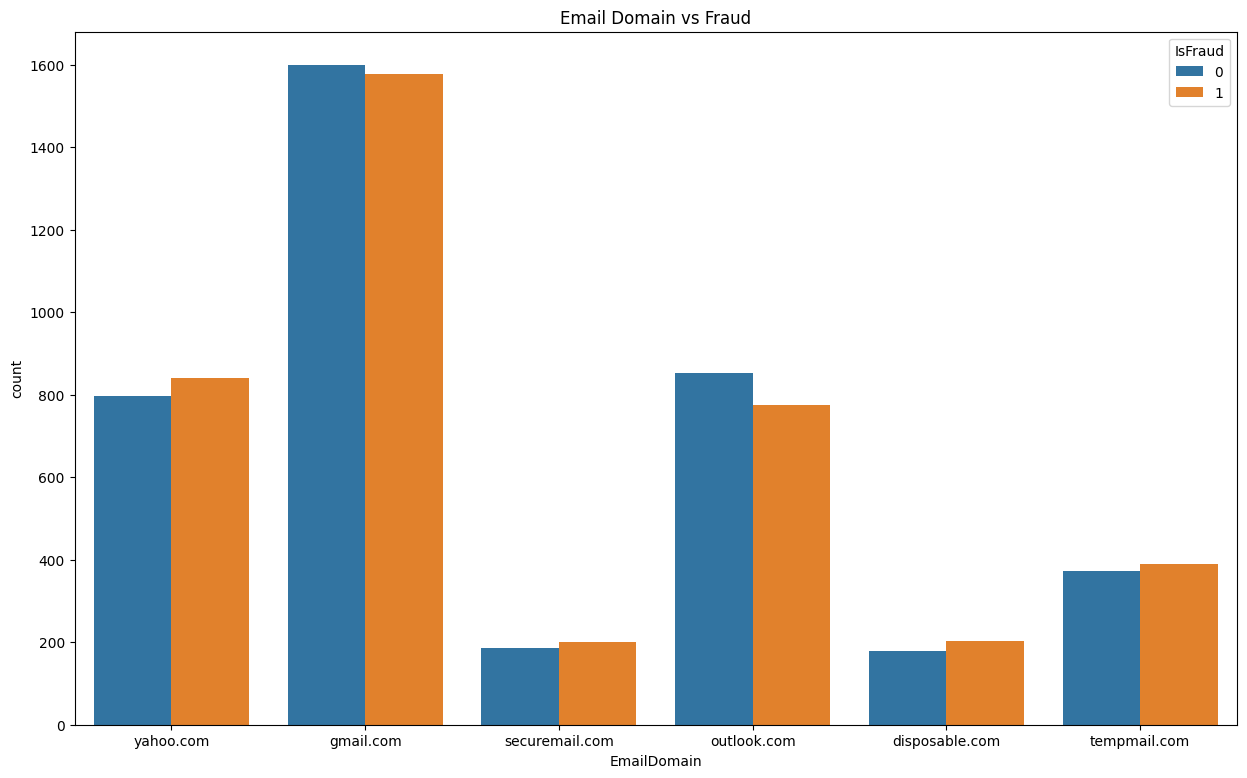

In [269]:
# Compare different email domains to see if there is a correlation between email domain and fraud
# Plot
plt.figure(figsize=(15, 9))
sns.countplot(x='EmailDomain', data=train_data, hue='IsFraud')
plt.title('Email Domain vs Fraud')
plt.show()

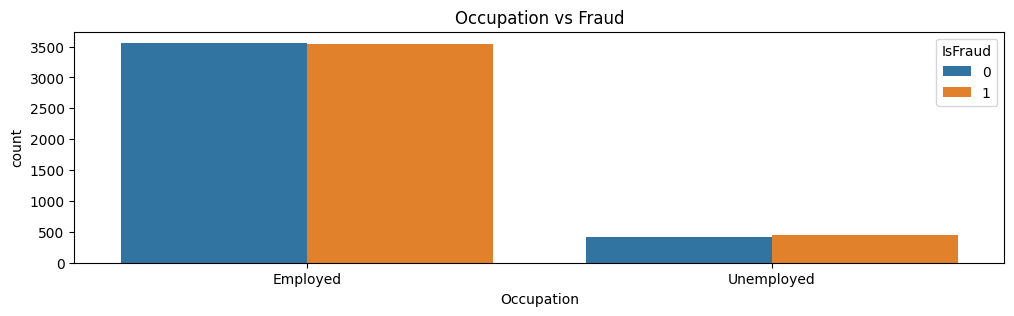

In [189]:
# Identify if unemployed individuals are more likely to engage in fraud compared to professionals, students, or retirees.
train_data['Occupation'] = train_data['Occupation'].apply(lambda x: 'Unemployed' if x == 'Unemployed' else 'Employed')

# Plot the Occupation column
sns.countplot(x='Occupation', data=train_data, hue='IsFraud')
plt.title('Occupation vs Fraud')
plt.show()

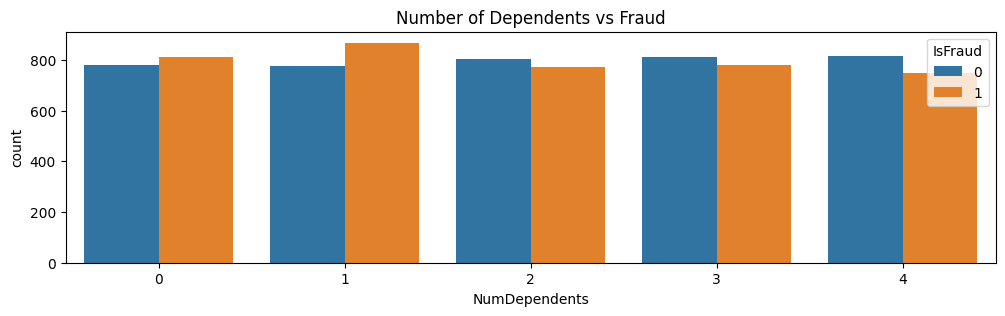

In [190]:
#  Check if having fewer dependents correlates with a higher likelihood of committing fraud.
# Plot the NumDependents column
sns.countplot(x='NumDependents', data=train_data, hue='IsFraud')
plt.title('Number of Dependents vs Fraud')
plt.show()

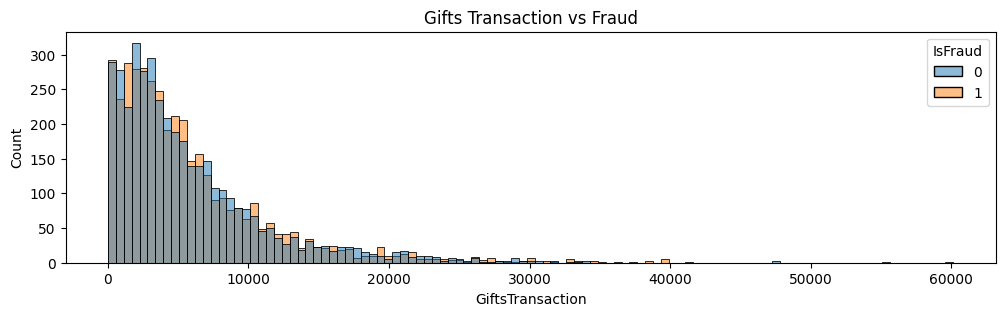

In [191]:
# Determine whether fraudsters have higher gift transaction amounts than non-fraudsters.
# Plot the GiftsTransaction column
sns.histplot(x='GiftsTransaction', data=train_data, hue='IsFraud')
plt.title('Gifts Transaction vs Fraud')
plt.show()

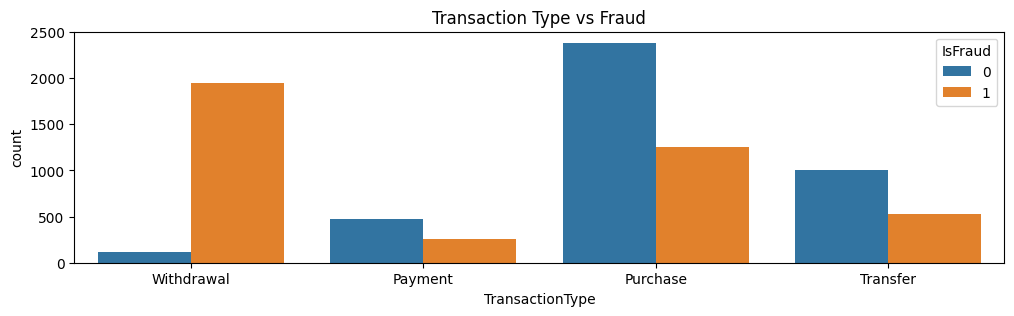

In [192]:
# Identify which types of transactions (withdrawals, purchases, payments, transfers) occur most frequently before a fraudulent event. Are some types (e.g., purchases) more commonly linked to fraud?
# Plot the TransactionType column
sns.countplot(x='TransactionType', data=train_data, hue='IsFraud')
plt.title('Transaction Type vs Fraud')
plt.show()

In [193]:
# Get the UserID that has most fraud
train_data[train_data['IsFraud'] == 1]['UserID'].value_counts()

UserID
2479    8
2616    7
4052    7
1077    7
1951    7
       ..
2818    1
329     1
3630    1
3602    1
3608    1
Name: count, Length: 2383, dtype: int64

In [194]:
fraud_counts = train_data[train_data['IsFraud'] == 1]['UserID'].value_counts()
frequency_of_counts = fraud_counts.value_counts()
print(frequency_of_counts) 

count
1    1419
2     578
3     219
4     111
5      35
6      14
7       6
8       1
Name: count, dtype: int64


In [195]:
# Gimme info of the UserID with most fraud
train_data[train_data['UserID'] == 3608]

,TransactionNumber,UserID,Age,Gender,Occupation,EducationLevel,MaritalStatus,NumDependents,Income,Expenditure,...,IsFraud,Date,Month,Weekday,Income_Currency,Expenditure_Currency,GiftsTransaction_Currency,TransactionAmount_Currency,AgeGroup,IncomeGroup
1927,6948,3608,31,Female,Employed,PhD,Married,1,113393.81,67250.820,...,0,15,12,Friday,AUD,AUD,GBP,AUD,Young Adult,Upper Middle
2405,15706,3608,31,Female,Employed,PhD,Married,1,113393.81,58609.089,...,0,14,12,Thursday,AUD,AED,AUD,AED,Young Adult,Upper Middle
10965,15795,3608,31,Female,Employed,PhD,Married,1,113393.81,58609.089,...,1,16,12,Saturday,AUD,AED,AUD,AED,Young Adult,Upper Middle


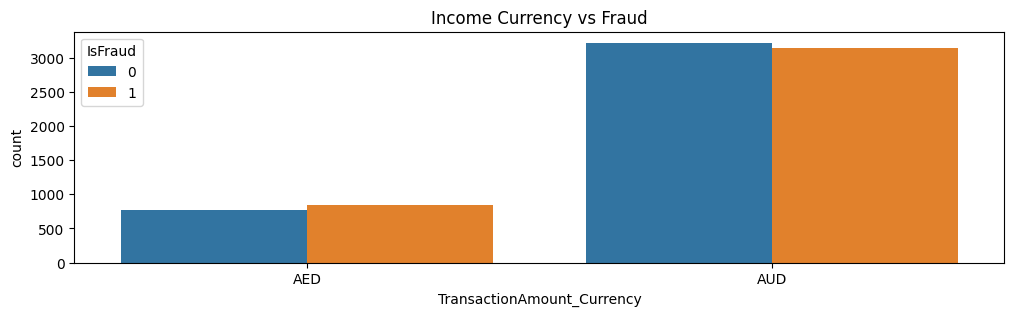

In [196]:
# gimme income_currency against fraud plot
sns.countplot(x='TransactionAmount_Currency', data=train_data, hue='IsFraud')
plt.title('Income Currency vs Fraud')
plt.show()

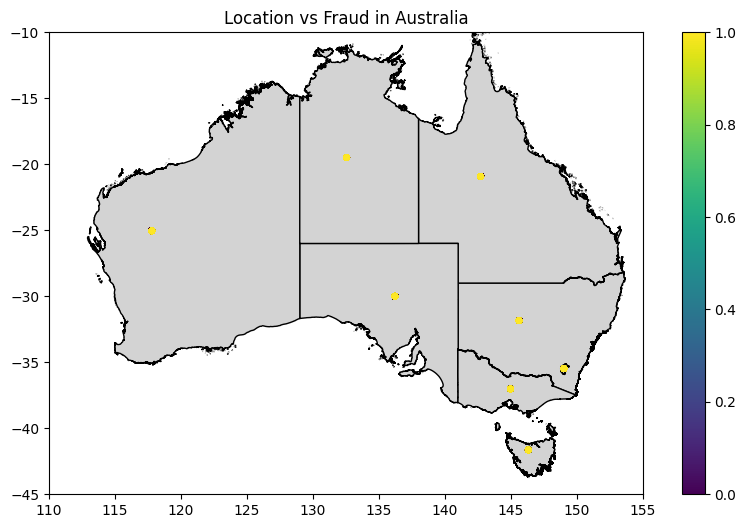

In [197]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os

geometry = gpd.points_from_xy(train_data['Longitude'], train_data['Latitude'])
geo_df = gpd.GeoDataFrame(train_data, geometry=geometry)

os.environ['SHAPE_RESTORE_SHX'] = 'YES' 
australia = gpd.read_file('STE_2021_AUST_GDA2020.shp') 

fig, ax = plt.subplots(figsize=(10, 6))
ax.set_xlim(110, 155)  # Longitude limits
ax.set_ylim(-45, -10)  # Latitude limits
australia.plot(ax=ax, color='lightgray', edgecolor='black') 
geo_df.plot(ax=ax, column='IsFraud', markersize=15, legend=True, cmap='viridis') 

plt.title('Location vs Fraud in Australia')
plt.show() 


<Axes: xlabel='UserTenureGroup', ylabel='count'>

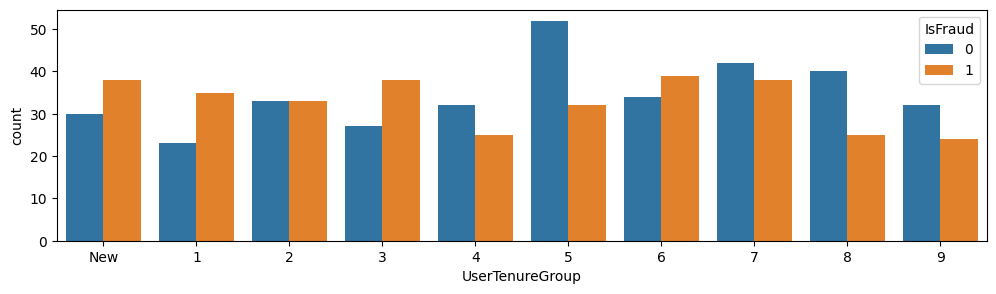

In [198]:
# does new account cause more fraud?
train_data['UserTenureGroup'] = pd.cut(train_data['UserTenure'], bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10], labels=['New', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

# Plot the UserTenureGroup column
sns.countplot(x='UserTenureGroup', data=train_data, hue='IsFraud')

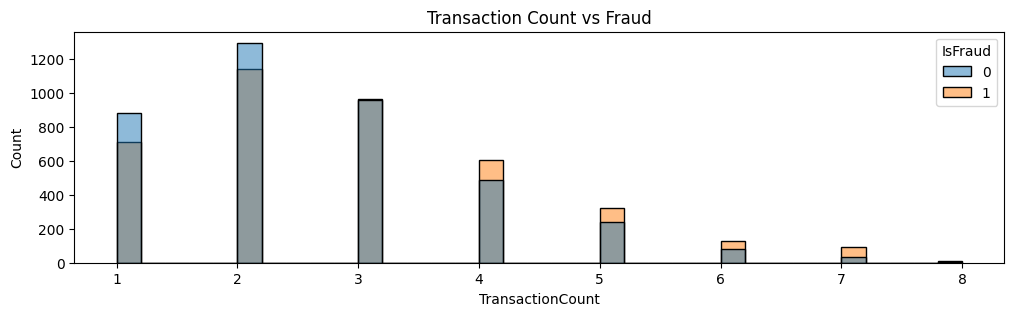

In [199]:
# How many transaction before a fraud?
train_data['TransactionCount'] = train_data.groupby('UserID')['UserID'].transform('count')

# Plot the TransactionCount column
sns.histplot(x='TransactionCount', data=train_data, hue='IsFraud')
plt.title('Transaction Count vs Fraud')
plt.show()

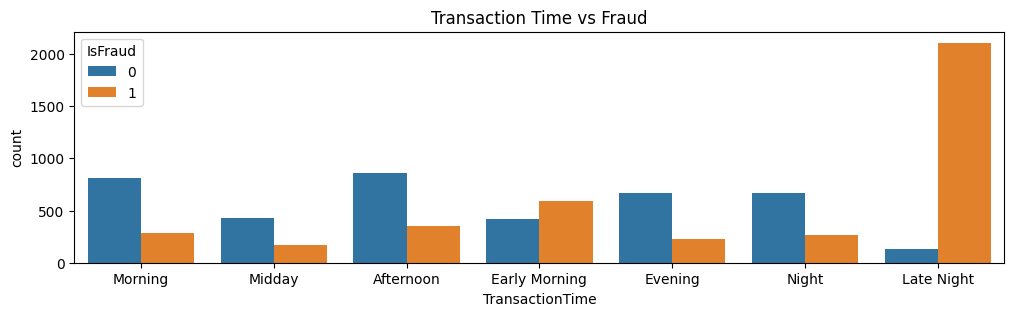

In [200]:
# does late night = more fraud?
sns.countplot(x='TransactionTime', data=train_data, hue='IsFraud')
plt.title('Transaction Time vs Fraud')
plt.show()

### Trash

In [201]:
# make default plot smaller
plt.rcParams['figure.figsize'] = [12, 3]

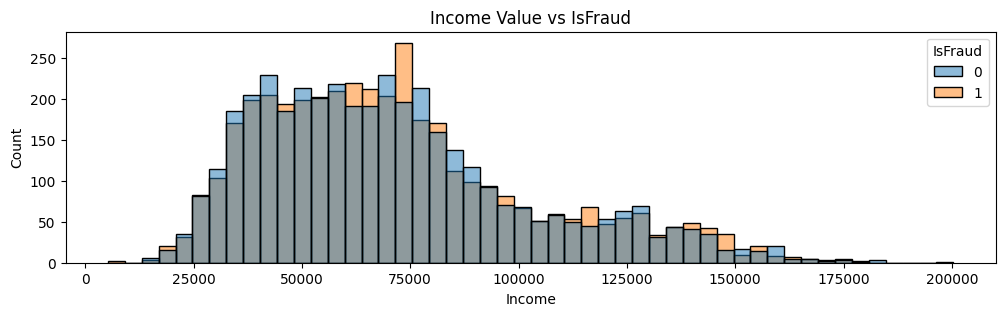

In [202]:
# Plot the income against the isFraud, histogram
sns.histplot(x='Income', hue='IsFraud', data=train_data)
plt.title('Income Value vs IsFraud')
plt.show()

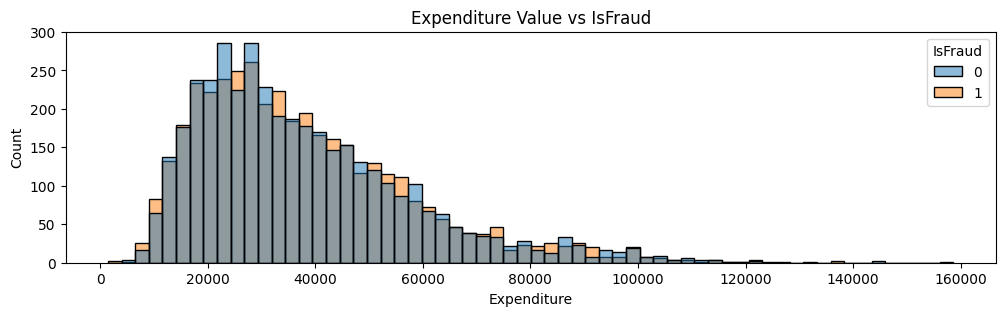

In [203]:
# Plot expenditure value against the isFraud, histogram
sns.histplot(x='Expenditure', hue='IsFraud', data=train_data)
plt.title('Expenditure Value vs IsFraud')
plt.show()

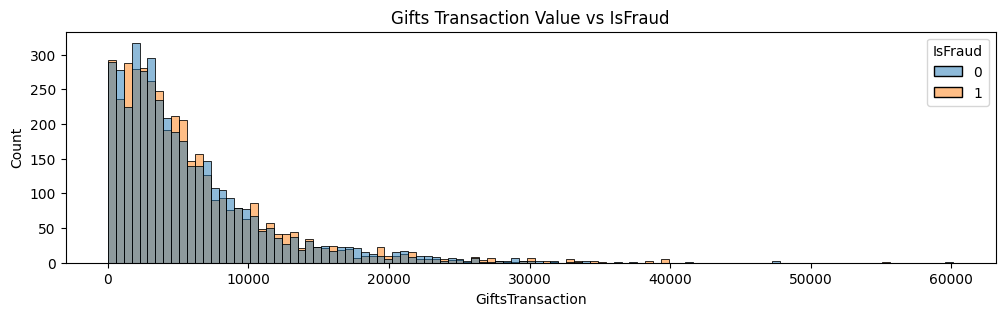

In [204]:
# Plot gifts transaction value against the isFraud, histogram
sns.histplot(x='GiftsTransaction', hue='IsFraud', data=train_data)
plt.title('Gifts Transaction Value vs IsFraud')
plt.show()

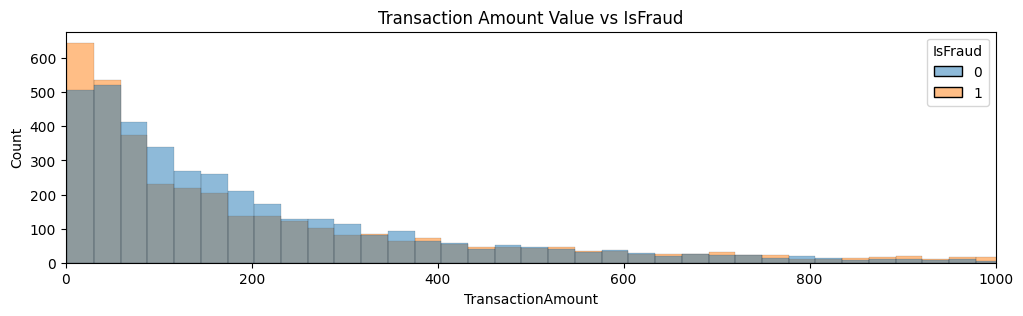

In [205]:
# Plot transaction amount value against the isFraud, histogram, zoom into the range of 0 to 1000
sns.histplot(x='TransactionAmount', hue='IsFraud', data=train_data)
plt.xlim(0, 1000)
plt.title('Transaction Amount Value vs IsFraud')
plt.show()

In [206]:
# Check correlation between the features: Income, Expenditure, GiftsTransaction, TransactionAmount, and IsFraud
train_data[['Income', 'Expenditure', 'GiftsTransaction', 'TransactionAmount', 'IsFraud']].corr()

,Income,Expenditure,GiftsTransaction,TransactionAmount,IsFraud
Income,1.000000,0.825134,0.434225,0.007915,0.012635
Expenditure,0.825134,1.000000,0.355140,0.004657,0.000034
GiftsTransaction,0.434225,0.355140,1.000000,-0.006611,0.006341
TransactionAmount,0.007915,0.004657,-0.006611,1.000000,0.106198
IsFraud,0.012635,0.000034,0.006341,0.106198,1.000000


=> Transaction amount, expenditure, and gift transaction values have little correlation with IsFraud

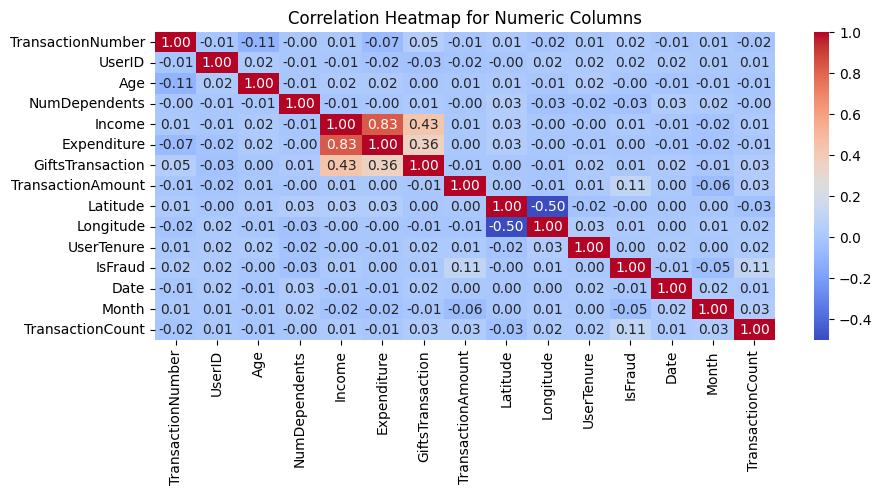

In [207]:
# Select only the numeric columns
numeric_data = train_data.select_dtypes(include=['number'])

# Calculate the correlation matrix for numeric columns
correlation_matrix = numeric_data.corr()

# Create a heatmap
plt.figure(figsize=(10, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap for Numeric Columns')
plt.show()

## Encoding

In [208]:
def binary_encode(df, column, positive_value):
    df = df.copy()
    df[column] = df[column].apply(lambda x: 1 if x == positive_value else 0)
    return df

def ordinal_encode(df, column, ordering):
    df = df.copy()
    df[column] = df[column].apply(lambda x: ordering.index(x))
    return df


In [209]:
education_order = [
    "High School","Bachelor","Master","PhD"
]
nomial_columns = ["Occupation", "Income_Currency", "Expenditure_Currency", "GiftsTransaction_Currency", "TransactionAmount_Currency", "TransactionTime","DeviceType", "MerchantID", "EmailDomain", "Weekday", "MaritalStatus", "TransactionType", "TransactionLocation", "AgeGroup", "IncomeGroup", "UserTenureGroup"]

In [210]:
train_data = binary_encode(train_data, "Gender", "Male")
train_data = ordinal_encode(train_data, "EducationLevel", education_order)
train_data = binary_encode(train_data, "Terrorism", True)
# One hot encoding for the rest
train_data = pd.get_dummies(train_data, columns=nomial_columns, prefix=nomial_columns)

In [211]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7970 entries, 2349 to 10965
Data columns (total 91 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   TransactionNumber               7970 non-null   int64  
 1   UserID                          7970 non-null   int64  
 2   Age                             7970 non-null   int64  
 3   Gender                          7970 non-null   int64  
 4   EducationLevel                  7970 non-null   int64  
 5   NumDependents                   7970 non-null   int64  
 6   Income                          7970 non-null   float64
 7   Expenditure                     7970 non-null   float64
 8   GiftsTransaction                7970 non-null   float64
 9   TransactionAmount               7970 non-null   float64
 10  Latitude                        7970 non-null   float64
 11  Longitude                       7970 non-null   float64
 12  Terrorism                       797

In [212]:
# Calculate the correlation matrix
correlation_matrix = train_data.corr()

# Get the correlation of all features with 'IsFraud'
isfraud_correlation = correlation_matrix['IsFraud']

# Sort the correlations in descending order (highest correlation first)
top_20_correlation = isfraud_correlation.sort_values(ascending=False)[:20]

# Print the top 20 correlations
print("Top 20 Features with Highest Correlation with IsFraud:")
print(top_20_correlation)

Top 20 Features with Highest Correlation with IsFraud:
IsFraud                           1.000000
TransactionTime_Late Night        0.551905
TransactionType_Withdrawal        0.523978
TransactionCount                  0.107809
TransactionAmount                 0.106198
TransactionTime_Early Morning     0.063472
TransactionLocation_Brisbane      0.038739
TransactionLocation_Adelaide      0.038182
TransactionLocation_Hobart        0.036869
TransactionLocation_Sydney        0.036757
TransactionLocation_Perth         0.034603
AgeGroup_Elderly                  0.029897
TransactionLocation_Darwin        0.029463
TransactionLocation_Canberra      0.024926
EmailDomain_yahoo.com             0.023784
TransactionNumber                 0.022956
Expenditure_Currency_AED          0.022839
GiftsTransaction_Currency_AUD     0.022839
TransactionAmount_Currency_AED    0.022839
UserTenureGroup_1                 0.017714
Name: IsFraud, dtype: float64


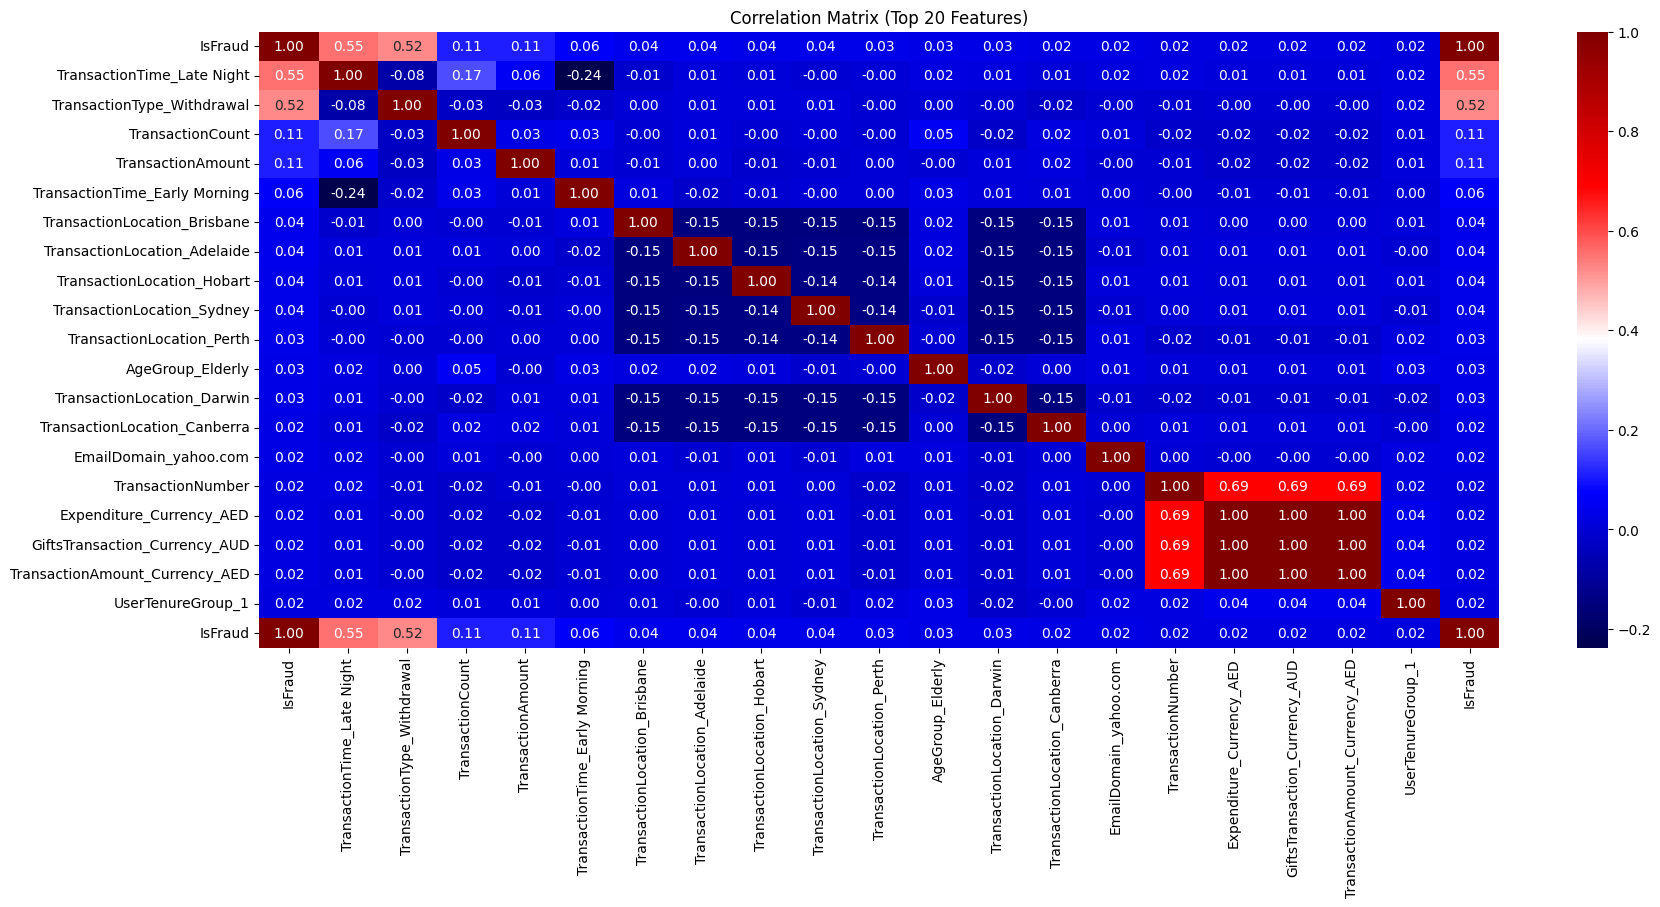

In [213]:
# Get the top 20 features 
top_20_features = top_20_correlation.index.tolist()
top_20_features.append('IsFraud') # Include IsFraud to show in plot
top_20_correlation_matrix = correlation_matrix.loc[top_20_features, top_20_features]
plt.figure(figsize=(20, 8))
sns.heatmap(top_20_correlation_matrix, annot=True, cmap='seismic', fmt=".2f")  
plt.title('Correlation Matrix (Top 20 Features)')
plt.show() 

## Modeling

In [214]:
test_df

,TransactionNumber,UserID,Age,Gender,Occupation,EducationLevel,MaritalStatus,NumDependents,Income,Expenditure,...,TransactionAmount,MerchantID,TransactionType,TransactionLocation,DeviceType,Latitude,Longitude,EmailDomain,Terrorism,UserTenure
0,11854,963,35,man,Student,Bachelor,Single,4,53733.41 AUD,AU$ 29296.02,...,AU$ 225.64,M005,Payment,Darwin,Desktop,-37.020100,144.964600,chapmangabriel@outlook.com,True,39
1,2647,1693,23,Male,Professional,Master,Single,2,54856.77 AUD,34628.31 AUD,...,AU$ 658.1,M003,Purchase,Darwin,Desktop,-37.020100,144.964600,sjones@gmail.com,True,65
2,5945,4383,44,Male,Student,Bachelor,Single,2,59011.72 AUD,33312.46 AUD,...,AU$ 133.59,M004,Purchase,Adelaide,mob,-30.000233,136.209152,woodmaria@yahoo.com,False,95
3,6798,1350,40,Male,Student,High School,Married,3,AU$ 128795.4,67049.0 AUD,...,AU$ 6.74,M008,Withdrawal,Canberra,Mobile,-37.020100,144.964600,rthornton@gmail.com,False,85
4,12985,4145,18,Male,Professional,Bachelor,Married,3,AU$ 44506.03,22856.31 AUD,...,15.67 AUD,M008,Transfer,Perth,Tablet,-20.917574,142.702789,daniel61@outlook.com,True,102
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7307,2636,498,40,Female,Student,High School,Married,4,46099.15 AUD,AU$ 23638.96,...,370.89 AUD,M007,Withdrawal,Perth,Desktop,-37.020100,144.964600,theresachavez@gmail.com,False,87
7308,14557,4707,52,Male,Unemployed,Master,Married,0,148540.21 AUD,76153.21 AUD,...,AU$ 48.35,M008,Purchase,Brisbane,mob,-31.840233,145.612793,bsmith@yahoo.com,False,39
7309,296,1426,42,Male,Student,Bachelor,Single,3,AU$ 62223.32,AU$ 25581.85,...,AU$ 110.23,M006,Transfer,Hobart,Mobile,-37.020100,144.964600,hensonernest@gmail.com,True,74
7310,1864,4605,39,Female,Student,PhD,Married,0,AU$ 119426.16,AU$ 85940.02,...,AU$ 202.37,M008,Purchase,Darwin,Mobile,-31.840233,145.612793,kschultz@gmail.com,True,18


/home/quan/miniconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3204, number of negative: 3172
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000864 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1993
[LightGBM] [Info] Number of data points in the train set: 6376, number of used features: 87
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502509 -> initscore=0.010038
[LightGBM] [Info] Start training from score 0.010038
Learning rate set to 0.022724
0:	learn: 0.6363085	total: 5.04ms	remaining: 5.03s
1:	learn: 0.5862591	total: 9.02ms	remaining: 4.5s
2:	learn: 0.5395218	total: 13.2ms	remaining: 4.4s
3:	learn: 0.4994862	total: 17.5ms	remaining: 4.36s
4:	learn: 0.4597872	total: 22.2ms	remaining: 4.42s
5:	learn: 0.4260209	total: 26.9ms	remaining: 4.46s
6:	learn: 0.3914744	total: 30.6ms

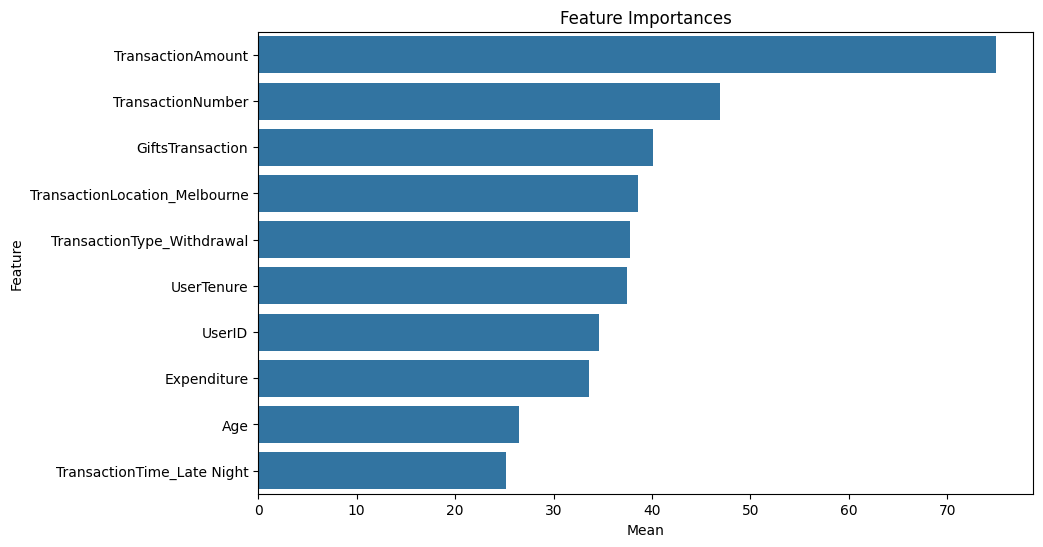

In [227]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(train_data.drop('IsFraud', axis=1), train_data['IsFraud'], test_size=0.2, random_state=42)

# Initialize the models
lres = LogisticRegression()
rf = RandomForestClassifier()
xgb = XGBClassifier()
lgbm = LGBMClassifier()
cat = CatBoostClassifier()

# Fit the models
lres.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train.values, y_train.values)
lgbm.fit(X_train, y_train)
cat.fit(X_train, y_train)

# Predict the target
lres_pred = lres.predict(X_test)
rf_pred = rf.predict(X_test)
xgb_pred = xgb.predict(X_test)
lgbm_pred = lgbm.predict(X_test)
cat_pred = cat.predict(X_test)

# Calculate the F1-score
rf_f1 = f1_score(y_test, rf_pred)
xgb_f1 = f1_score(y_test, xgb_pred)
lgbm_f1 = f1_score(y_test, lgbm_pred)
cat_f1 = f1_score(y_test, cat_pred)

print(f"Random Forest F1-Score: {rf_f1}")
print(f"XGBoost F1-Score: {xgb_f1}")
print(f"LightGBM F1-Score: {lgbm_f1}")
print(f"CatBoost F1-Score: {cat_f1}") 

# Get the feature importances
lgr_importances = lres.coef_[0]
rf_importances = rf.feature_importances_
xgb_importances = xgb.feature_importances_
lgbm_importances = lgbm.feature_importances_
cat_importances = cat.feature_importances_

# Create a DataFrame
importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Logistic Regression': lgr_importances,
    'Random Forest': rf_importances,
    'XGBoost': xgb_importances,
    'LightGBM': lgbm_importances,
    'CatBoost': cat_importances
})

# Calculate the mean importance
importances_df['Mean'] = importances_df.drop('Feature', axis=1).mean(axis=1)
# Sort the DataFrame
importances_df = importances_df.sort_values(by='Mean', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=importances_df.head(10), x='Mean', y='Feature')
plt.title('Feature Importances')
plt.show()

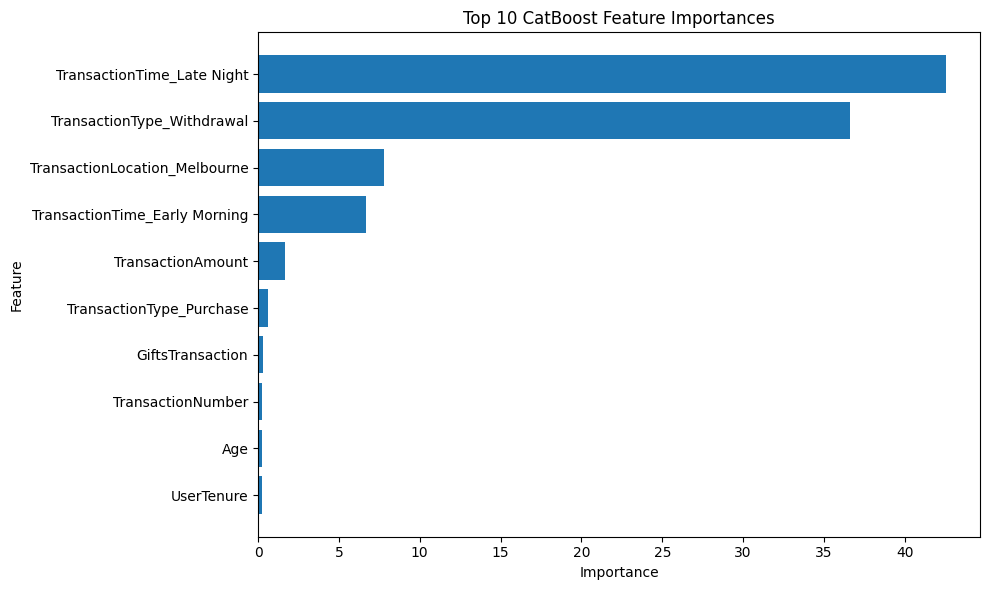

In [216]:
cat_importances = cat.feature_importances_

# Create a DataFrame for visualization
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': cat_importances
})

# Sort features by importance
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Select only the top 10 features
top_10_features = feature_importances_df.head(10)

# Visualize the top 10 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 CatBoost Feature Importances")
plt.gca().invert_yaxis()  # Invert y-axis to show most important features at the top
plt.tight_layout()
plt.show() 

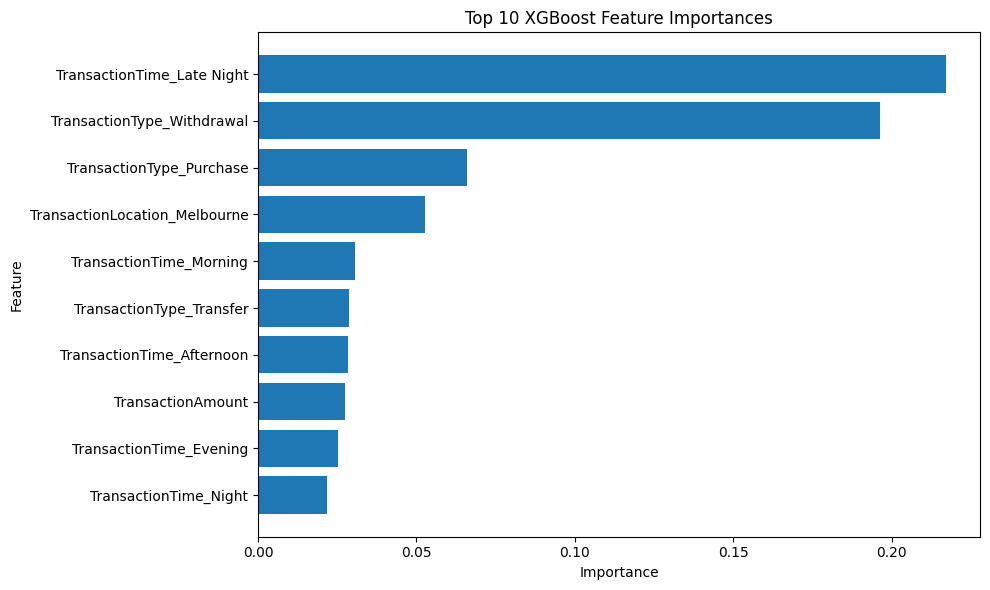

In [217]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd

# ... (your data loading and preprocessing code here) ...
# Create a DataFrame for visualization
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': rf_importances
})

# Sort features by importance
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)

# Select only the top 10 features
top_10_features = feature_importances_df.head(10)

# Visualize the top 10 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_10_features['Feature'], top_10_features['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Top 10 XGBoost Feature Importances")
plt.gca().invert_yaxis()  # Invert y-axis to show most important features at the top
plt.tight_layout()
plt.show() 


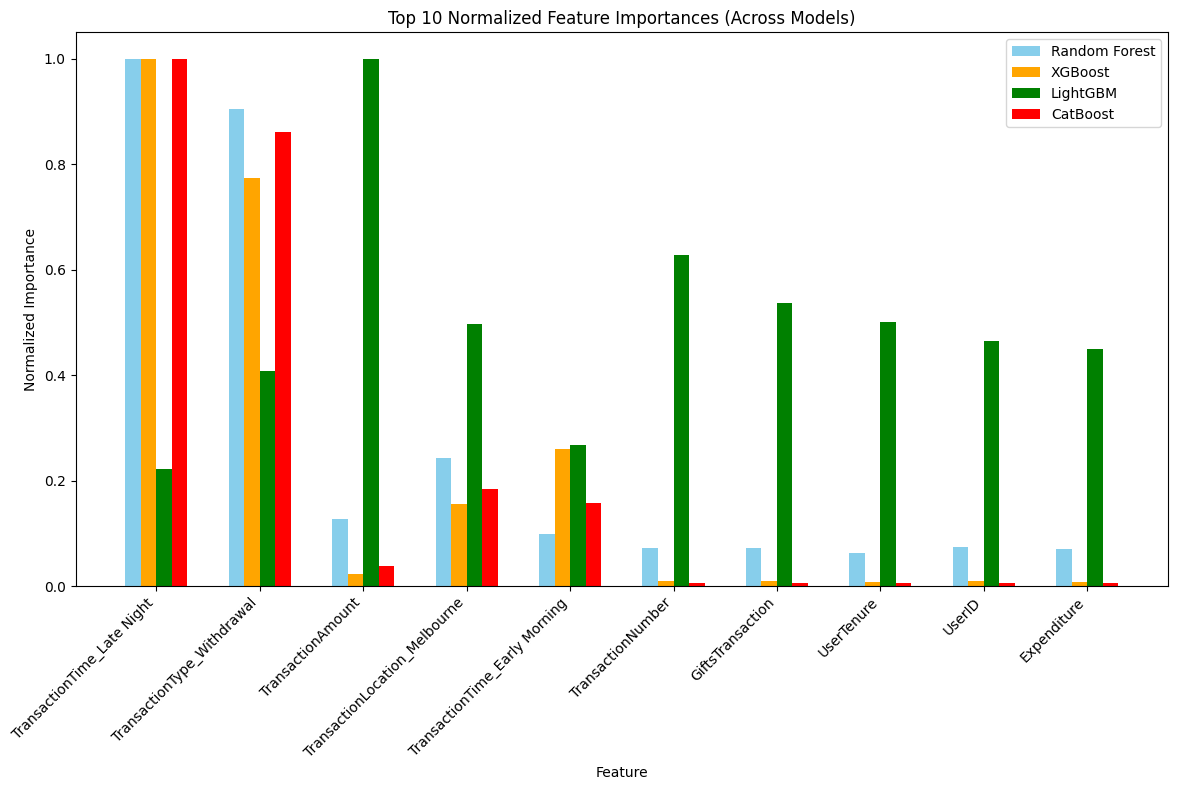

In [218]:
# Import necessary libraries
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# ... (your data loading and preprocessing code here) ...
# ... (your model initialization and fitting code here) ... 

# Get feature importances for all models
rf_importances = rf.feature_importances_
lgbm_importances = lgbm.feature_importances_
cat_importances = cat.feature_importances_

# Create a DataFrame for visualization
feature_importances_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Random Forest': rf_importances,
    'XGBoost': xgb_importances,
    'LightGBM': lgbm_importances,
    'CatBoost': cat_importances
})


# Normalize the feature importances for each model
scaler = MinMaxScaler()

feature_importances_df[['Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']] = \
    scaler.fit_transform(feature_importances_df[['Random Forest', 'XGBoost', 'LightGBM', 'CatBoost']])

# Calculate the mean importance
feature_importances_df['Mean'] = feature_importances_df.drop('Feature', axis=1).mean(axis=1)

# Sort features by mean importance
feature_importances_df = feature_importances_df.sort_values('Mean', ascending=False)


# Select only the top 10 features based on mean importance
top_10_features = feature_importances_df.head(10)

# Visualize the top 10 feature importances
plt.figure(figsize=(12, 8))  # Increase figure size for better visibility

# Create a bar plot with multiple colors for each model
width = 0.15  # Adjust width for better spacing between bars
x = np.arange(len(top_10_features['Feature']))

plt.bar(x - 1.5 * width, top_10_features['Random Forest'], width, label='Random Forest', color='skyblue')
plt.bar(x - 0.5 * width, top_10_features['XGBoost'], width, label='XGBoost', color='orange')
plt.bar(x + 0.5 * width, top_10_features['LightGBM'], width, label='LightGBM', color='green')
plt.bar(x + 1.5 * width, top_10_features['CatBoost'], width, label='CatBoost', color='red')

plt.xlabel("Feature")
plt.ylabel("Normalized Importance")
plt.title("Top 10 Normalized Feature Importances (Across Models)")
plt.xticks(x, top_10_features['Feature'], rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.legend()
plt.tight_layout()
plt.show() 


### Hypertuning

In [233]:
# Initialize the model
cat = CatBoostClassifier(verbose=0)

# Define a smaller range of hyperparameters
params = {
    'iterations': [100, 300, 500],
    'learning_rate': [0.3, 0.5, 0.7, 0.9],
    'depth': [2, 4, 6],
    'l2_leaf_reg': [1, 3, 4, 8],  # L2 regularization
    'bagging_temperature': [0.5, 1.0],  # Bootstrapping
}

# Define stratified cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

# Use RandomizedSearchCV with a limited number of iterations
grid_search = RandomizedSearchCV(cat, param_distributions=params, n_iter=10, cv=cv, n_jobs=-1, scoring='f1', random_state=42)

# Fit the grid search
grid_search.fit(X_train, y_train, early_stopping_rounds=30, eval_set=(X_test, y_test))

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Initialize the model with the best parameters
cat = CatBoostClassifier(**best_params, verbose=0, random_state=42)

# Fit the model using early stopping
cat.fit(X_train, y_train, early_stopping_rounds=30, eval_set=(X_test, y_test))

# Predict the target
cat_pred = cat.predict(X_test)

# Calculate accuracy and F1-score
cat_acc = accuracy_score(y_test, cat_pred)
cat_f1 = f1_score(y_test, cat_pred)

# Print the results
print(f"CatBoost Accuracy: {cat_acc}")
print(f"CatBoost F1-Score: {cat_f1}")

# Best Parameters: {'learning_rate': 0.1, 'l2_leaf_reg': 1, 'iterations': 100, 'depth': 6, 'bagging_temperature': 1.0}
# Best Parameters: {'learning_rate': 0.3, 'l2_leaf_reg': 1, 'iterations': 500, 'depth': 6, 'bagging_temperature': 1.0}
# Best Parameters: {'learning_rate': 0.7, 'l2_leaf_reg': 4, 'iterations': 500, 'depth': 2, 'bagging_temperature': 0.5}
# Best Parameters: {'learning_rate': 0.5, 'l2_leaf_reg': 8, 'iterations': 500, 'depth': 2, 'bagging_temperature': 0.5}

Best Parameters: {'learning_rate': 0.7, 'l2_leaf_reg': 4, 'iterations': 500, 'depth': 2, 'bagging_temperature': 0.5}
CatBoost Accuracy: 0.9573400250941029
CatBoost F1-Score: 0.9567430025445293


## Prediction

In [234]:
test_df = pd.read_csv(path + "test.csv")

In [235]:
# Create a pipeline to transform test data
test_df['TransactionTime'] = test_df['TransactionTime'].apply(standard_time)
test_df['TransactionTime'] = pd.to_datetime(test_df['TransactionTime'], format='%H:%M:%S').dt.hour
test_df['TransactionTime'] = test_df['TransactionTime'].apply(categorize_time)

test_df['TransactionDate'] = pd.to_datetime(test_df['TransactionDate'], format='mixed', dayfirst=True, errors='coerce')

test_df['Date'] = test_df['TransactionDate'].dt.day
test_df['Month'] = test_df['TransactionDate'].dt.month
test_df['Weekday'] = test_df['TransactionDate'].dt.day_name()

test_df.drop(columns=['TransactionDate'], inplace=True)

test_df['Income'], test_df['Income_Currency'] = zip(*test_df['Income'].apply(get_currency_and_symbol))
test_df['Income'] = pd.to_numeric(test_df['Income'], errors='coerce')

test_df['Expenditure'], test_df['Expenditure_Currency'] = zip(*test_df['Expenditure'].apply(get_currency_and_symbol))
test_df['Expenditure'] = pd.to_numeric(test_df['Expenditure'], errors='coerce')

test_df['GiftsTransaction'], test_df['GiftsTransaction_Currency'] = zip(*test_df['GiftsTransaction'].apply(get_currency_and_symbol))
test_df['GiftsTransaction'] = pd.to_numeric(test_df['GiftsTransaction'], errors='coerce')

test_df['TransactionAmount'], test_df['TransactionAmount_Currency'] = zip(*test_df['TransactionAmount'].apply(get_currency_and_symbol))
test_df['TransactionAmount'] = pd.to_numeric(test_df['TransactionAmount'], errors='coerce') 

test_df['EmailDomain'] = test_df['EmailDomain'].apply(lambda x: x.split('@')[1])
test_df['Gender'] = test_df['Gender'].map(gender_mapping).fillna('Other')
test_df['DeviceType'] = test_df['DeviceType'].apply(lambda x: 'Mobile' if x in ['mob', 'smartphone', 'iphone 15', 'galaxys7', 'android'] else x)

In [236]:
# One hot encoding
test_df = binary_encode(test_df, "Gender", "Male")
test_df = ordinal_encode(test_df, "EducationLevel", education_order)
test_df = binary_encode(test_df, "Terrorism", True)
# One hot encoding for the rest
columns_to_encode = ["Occupation", "Income_Currency", "Expenditure_Currency", "GiftsTransaction_Currency", "TransactionAmount_Currency", "TransactionTime","DeviceType", "MerchantID", "EmailDomain", "Weekday", "MaritalStatus", "TransactionType", "TransactionLocation"]
test_df = pd.get_dummies(test_df, columns=columns_to_encode, prefix=columns_to_encode)

In [237]:
# Predict on the test dataset
cat_pred = cat.predict(test_df)

CatBoostError: catboost/libs/data/model_dataset_compatibility.cpp:81: At position 16 should be feature with name TransactionCount (found Occupation_Professional).

In [225]:
result_df = pd.DataFrame({
    'TransactionNumber': test_df['TransactionNumber'],  # Replace 'TransactionID' with your column name
    'IsFraud': cat_pred
})

print(result_df)

# Save to a CSV file (optional)
# result_df.to_csv('submission2.csv', index=False)

ValueError: array length 1594 does not match index length 7312

## Misc

In [241]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# Assuming you have your DataFrame named 'train_data'

# Extract the 'IsFraud' column and prepare data
X = train_data[['IsFraud']] 

# Apply StandardScaler (optional but recommended)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) 

# Initialize and fit the KMeans model
kmeans = KMeans(n_clusters=2, random_state=42) 
kmeans.fit(X_scaled) 

# Get cluster assignments
train_data['IsFraud_Cluster'] = kmeans.labels_ 

# (Optional) Print some info to check results
print(train_data['IsFraud_Cluster'].value_counts()) 

IsFraud_Cluster
0    3985
1    3985
Name: count, dtype: int64


In [242]:
# Check the cluster centers
print(kmeans.cluster_centers_)

[[-1.]
 [ 1.]]
